<a href="https://colab.research.google.com/github/abarbierif/al_hw/blob/main/sw_design/classification/FashionMNISTSubset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### `libraries && functions`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.config import list_physical_devices
list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import sys
import tensorflow as tf
import pandas as pd
import pickle
from tensorflow.keras.preprocessing.image import smart_resize
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score
from sklearn.model_selection import StratifiedKFold

sys.path.append('/content/drive/MyDrive/AL_HW/pytools')
os.chdir('/content/drive/MyDrive/AL_HW/notebooks/Classifier_Selection')
os.getcwd()

'/content/drive/MyDrive/AL_HW/notebooks/Classifier_Selection'

In [ ]:
from data_loading import *
from data_visualization import *
from utils import *
from data_preprocessing import *

from CustomAlexNet import *
from CustomVGG16 import *
from CustomResNet50 import *
from CustomMobileNetV1 import *
from CustomMobileNetV2 import *
from CustomMobileNetV3Small import *
from CustomEfficientNetB0 import *

In [ ]:
#reproducibility (deterministic)
from tensorflow.keras.utils import set_random_seed
from tensorflow.config.experimental import enable_op_determinism

set_random_seed(1)
enable_op_determinism()

In [ ]:
def classifier(x=None, y=None, classifier=None, weights_path=None, write_file=None):

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    df = pd.DataFrame(columns=['fit_hist', 'loss', 'accuracy_score', 'f1_score'])
    df.loc[classifier] = ''

    for n, (train_idx, test_idx) in enumerate(skf.split(x, y)):

        if classifier == 'MobileNetV1':
            model = MobileNet(
                input_shape=(224,224,3),
                alpha=1.0,
                depth_multiplier=1,
                dropout=0.001,
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                pooling=None,
                classes=10,
                classifier_activation="softmax",
                name=None,
            )
        elif classifier == 'ResNet50':
            model = ResNet50(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=(224,224,3),
                pooling=None,
                classes=10,
                classifier_activation="softmax",
                name="resnet50",
            )
        elif classifier == 'efficientnetb0':
            model = EfficientNetB0(
                include_top=False,
                weights="imagenet",
                input_tensor=None,
                input_shape=(224,224,3),
                pooling=None,
                classes=10,
                classifier_activation="softmax",
                name="efficientnetb0",
            )

        model_output = model.output
        model_output = GlobalAveragePooling2D()(model_output)
        for layer in model.layers:
            layer.trainable = False
        model_output = Dense(10, activation="softmax", kernel_initializer=GlorotUniform(seed=1), bias_initializer=Zeros())(model_output)
        model = Model(inputs=model.input, outputs=model_output)
        model.summary()

        optimizer_adam = Adam(learning_rate=0.001)
        MC = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True, save_weights_only=True)
        SC = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

        model.compile(optimizer=optimizer_adam, loss='categorical_crossentropy', metrics=['accuracy', F1Score(average='weighted')])

        hist = model.fit(
            x=x[train_idx],
            y=preprocess_data(preprocess='onehot_encoding', labels_ndarray=y[train_idx]),
            batch_size=32,
            epochs=100,
            verbose=1,
            callbacks=[MC,SC],
            validation_split=0.2
        )

        score = model.evaluate(x=x[test_idx], y=preprocess_data(preprocess='onehot_encoding', labels_ndarray=y[test_idx]), verbose=1)

        df.loc[len(df)] = [hist, score[0], score[1], score[2]]

        del model

    df.loc['mean'] = ['', df['loss'][1:6].mean(), df['accuracy_score'][1:6].mean(), df['f1_score'][1:6].mean()]
    df.loc['std'] = ['', df['loss'][1:6].std(), df['accuracy_score'][1:6].std(), df['f1_score'][1:6].std()]

    if write_file:
        with open(write_file, 'wb') as f:
            pickle.dump(df, f)

### `load data`

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.IEQH52_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.IEQH52_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.
X shape (70000, 28, 28, 1)
y shape (70000,)
classes (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000]))


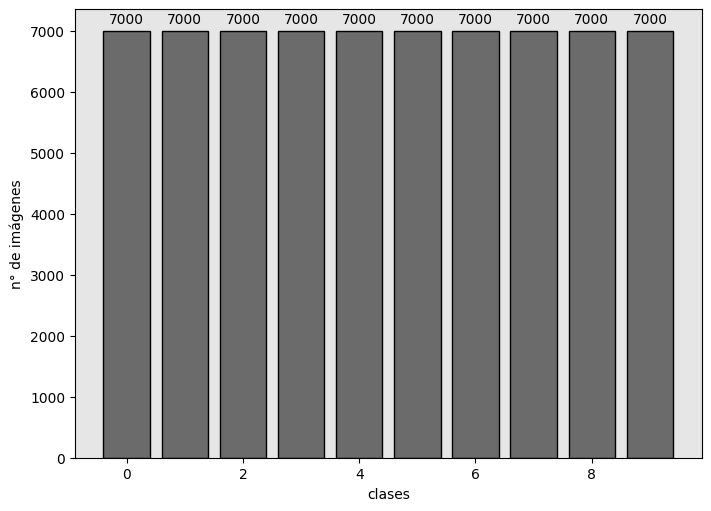

In [ ]:
X, y = load_data(
    source='tfds',
    to='ndarray',
    dataset='fashion_mnist',
    dims=(28,28)
)

print('X shape', X.shape)
print('y shape', y.shape)
print('classes', np.unique(y, return_counts=True))

classes_distribution(
    y,
    figsize=(7,5),
    title='',
    hatch='',
    cmap=None,
    xlabel='clases',
    ylabel='n° de imágenes',
    labelrotation=0,
    facecolor='#e6e6e6',
    color='#6b6b6b'
)

In [ ]:
def testing_data(X, Y, samples_per_class):

    if samples_per_class > np.max(np.unique(Y, return_counts=True)[1]):
        raise ValueError(f"samples_per_class must be less than {np.max(np.unique(Y, return_counts=True)[1])}")

    for _ in np.unique(Y):
        X = np.delete(X, np.argwhere(Y == _)[samples_per_class:], axis=0)
        Y = np.delete(Y, np.argwhere(Y == _)[samples_per_class:], axis=0)

    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    classes_distribution(Y, figsize=(7,5), title='', hatch='', cmap=None, xlabel='clases', ylabel='n° de imágenes', labelrotation=0, facecolor='#e6e6e6', color='#6b6b6b')

    return X, Y

X shape: (6400, 28, 28, 1), Y shape: (6400,)


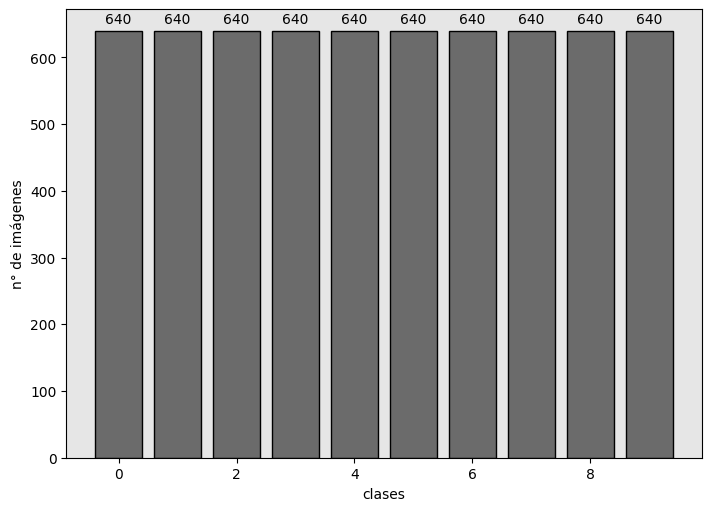

In [ ]:
X, y = testing_data(X, y, samples_per_class=640)

X shape: (6400, 224, 224, 3)
y shape: (6400,)
X type: uint8


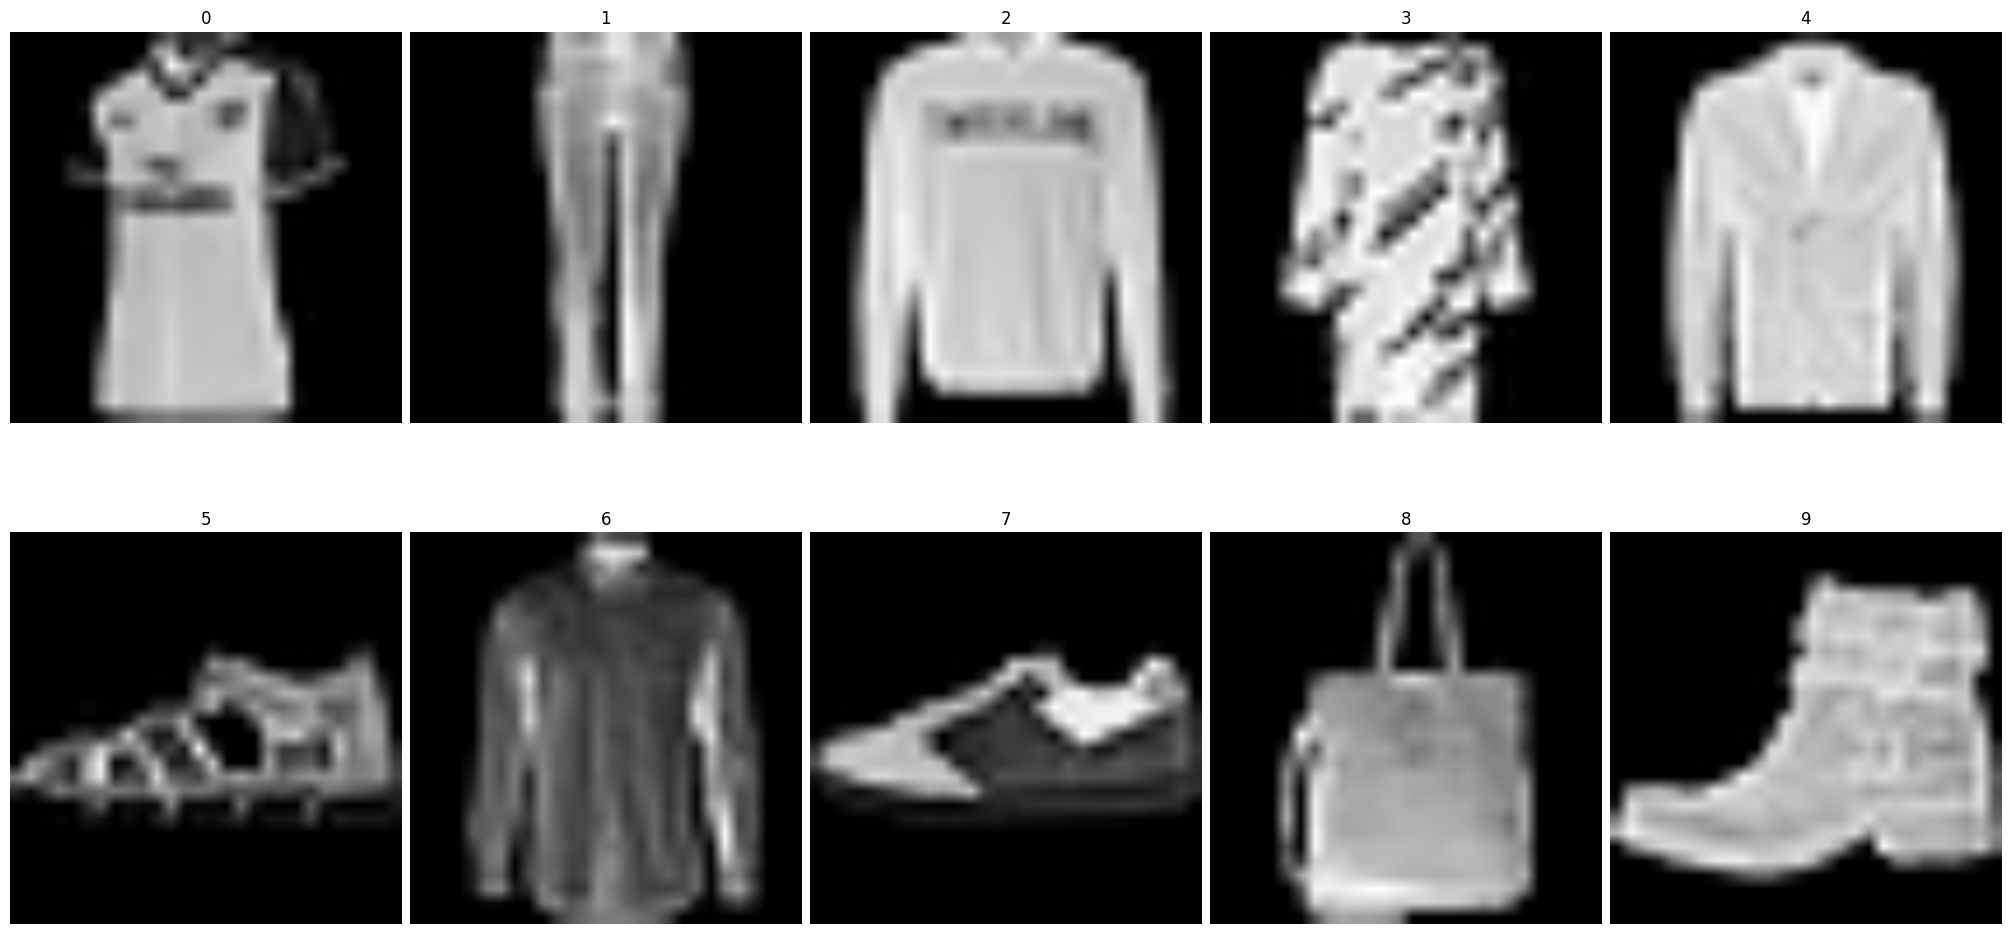

In [ ]:
#resizing && visualization
X = np.array([smart_resize(_, (224,224)) for _ in X])
X = np.array([img.repeat(3, axis=-1) for img in X])
X = X.astype("uint8")
print('X shape:', X.shape)
print('y shape:', y.shape)
print('X type:', X.dtype)
display_data(
    source='ndarray',
    rows=2,
    cols=5,
    x=X,
    y=y,
    display_mode='classes',
    figsize=(20,10),
    layout='constrained'
)

## `models training`

### `MobileNetV1`

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

X = preprocess_input(X)
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (6400, 224, 224, 3)
y shape: (6400,)


In [ ]:
classifier(
    x=X,
    y=y,
    classifier='MobileNetV1',
    weights_path='best_weights/FashionMNISTSubset512_MobileNetV1.weights.h5',
    write_file='results/df_FashionMNISTSubset512_MobileNetV1.pkl'
)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 16s 77ms/step - accuracy: 0.5647 - f1_score: 0.5652 - loss: 1.3713 - val_accuracy: 0.7910 - val_f1_score: 0.7740 - val_loss: 0.6018
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8260 - f1_score: 0.8219 - loss: 0.5061 - val_accuracy: 0.8232 - val_f1_score: 0.8120 - val_loss: 0.5088
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8608 - f1_score: 0.8585 - loss: 0.4153 - val_accuracy: 0.8350 - val_f1_score: 0.8251 - val_loss: 0.4733
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8805 - f1_score: 0.8788 - loss: 0.3631 - val_accuracy: 0.8447 - val_f1_score: 0.8362 - val_loss: 0.4529
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.8922 - f1_score: 0.8909 - loss: 0.3252 - val_accuracy: 0.8516 - val_f1_score: 0.8441 - val_loss: 0.4391
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.9011 - f1_score: 0.9000 - loss: 0.2952 - val_accuracy: 0.8545 - val_f1_

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - accuracy: 0.5770 - f1_score: 0.5742 - loss: 1.3010 - val_accuracy: 0.8369 - val_f1_score: 0.8349 - val_loss: 0.5276
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - accuracy: 0.8477 - f1_score: 0.8450 - loss: 0.4545 - val_accuracy: 0.8486 - val_f1_score: 0.8478 - val_loss: 0.4423
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8716 - f1_score: 0.8697 - loss: 0.3730 - val_accuracy: 0.8574 - val_f1_score: 0.8573 - val_loss: 0.4081
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8864 - f1_score: 0.8851 - loss: 0.3266 - val_accuracy: 0.8643 - val_f1_score: 0.8651 - val_loss: 0.3889
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8940 - f1_score: 0.8926 - loss: 0.2933 - val_accuracy: 0.8643 - val_f1_score: 0.8654 - val_loss: 0.3766
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9031 - f1_score: 0.9020 - loss: 0.2673 - val_accuracy: 0.8672 - val_f1_

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 81ms/step - accuracy: 0.5596 - f1_score: 0.5573 - loss: 1.3587 - val_accuracy: 0.8213 - val_f1_score: 0.8155 - val_loss: 0.5514
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8323 - f1_score: 0.8305 - loss: 0.4987 - val_accuracy: 0.8477 - val_f1_score: 0.8418 - val_loss: 0.4599
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8650 - f1_score: 0.8638 - loss: 0.4040 - val_accuracy: 0.8584 - val_f1_score: 0.8511 - val_loss: 0.4275
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8814 - f1_score: 0.8805 - loss: 0.3503 - val_accuracy: 0.8623 - val_f1_score: 0.8555 - val_loss: 0.4104
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8939 - f1_score: 0.8928 - loss: 0.3121 - val_accuracy: 0.8623 - val_f1_score: 0.8561 - val_loss: 0.3992
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9042 - f1_score: 0.9028 - loss: 0.2825 - val_accuracy: 0.8633 - val_f1_

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.5889 - f1_score: 0.5895 - loss: 1.2789 - val_accuracy: 0.8066 - val_f1_score: 0.8013 - val_loss: 0.5473
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8499 - f1_score: 0.8479 - loss: 0.4560 - val_accuracy: 0.8213 - val_f1_score: 0.8177 - val_loss: 0.4774
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8745 - f1_score: 0.8726 - loss: 0.3761 - val_accuracy: 0.8330 - val_f1_score: 0.8305 - val_loss: 0.4450
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8903 - f1_score: 0.8888 - loss: 0.3293 - val_accuracy: 0.8467 - val_f1_score: 0.8450 - val_loss: 0.4239
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9055 - f1_score: 0.9044 - loss: 0.2953 - val_accuracy: 0.8535 - val_f1_score: 0.8520 - val_loss: 0.4079
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9148 - f1_score: 0.9141 - loss: 0.2683 - val_accuracy: 0.8594 - val_f1_

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,239,114 (12.36 MB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.5828 - f1_score: 0.5821 - loss: 1.2812 - val_accuracy: 0.8125 - val_f1_score: 0.8134 - val_loss: 0.5392
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.8473 - f1_score: 0.8467 - loss: 0.4512 - val_accuracy: 0.8428 - val_f1_score: 0.8433 - val_loss: 0.4544
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8721 - f1_score: 0.8717 - loss: 0.3668 - val_accuracy: 0.8447 - val_f1_score: 0.8455 - val_loss: 0.4190
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.8936 - f1_score: 0.8933 - loss: 0.3168 - val_accuracy: 0.8506 - val_f1_score: 0.8513 - val_loss: 0.3989
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.9065 - f1_score: 0.9062 - loss: 0.2811 - val_accuracy: 0.8506 - val_f1_score: 0.8513 - val_loss: 0.3866
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step - accuracy: 0.9147 - f1_score: 0.9146 - loss: 0.2534 - val_accuracy: 0.8584 - val_f1_

In [ ]:
with open('results/df_FashionMNISTSubset512_MobileNetV1.pkl', 'rb') as f:
    df_MobileNetV1 = pickle.load(f)

df_MobileNetV1

fit_hist      loss  \
MobileNetV1                                                                
1            <keras.src.callbacks.history.History object at...  0.363711   
2            <keras.src.callbacks.history.History object at...  0.349446   
3            <keras.src.callbacks.history.History object at...  0.357762   
4            <keras.src.callbacks.history.History object at...  0.389589   
5            <keras.src.callbacks.history.History object at...  0.431251   
mean                                                            0.378352   
std                                                              0.03316   

            accuracy_score  f1_score  
MobileNetV1                           
1                 0.880469  0.879036  
2                 0.873438  0.873512  
3                 0.882812  0.878206  
4                 0.864062  0.862487  
5                 0.867188  0.868608  
mean              0.873594   0.87237  
std               0.008127  0.006922

In [ ]:
from google.colab import runtime
runtime.unassign()

### `ResNet50`

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

X = preprocess_input(X)
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (6400, 224, 224, 3)
y shape: (6400,)


In [ ]:
classifier(
    x=X,
    y=y,
    classifier='ResNet50',
    weights_path='best_weights/FashionMNISTSubset512_ResNet50.weights.h5',
    write_file='results/df_FashionMNISTSubset512_ResNet50.pkl'
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 33s 187ms/step - accuracy: 0.5882 - f1_score: 0.5863 - loss: 1.2636 - val_accuracy: 0.8223 - val_f1_score: 0.8178 - val_loss: 0.4902
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.8536 - f1_score: 0.8521 - loss: 0.4418 - val_accuracy: 0.8604 - val_f1_score: 0.8590 - val_loss: 0.4154
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.8828 - f1_score: 0.8822 - loss: 0.3594 - val_accuracy: 0.8691 - val_f1_score: 0.8680 - val_loss: 0.3875
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.8990 - f1_score: 0.8989 - loss: 0.3073 - val_accuracy: 0.8740 - val_f1_score: 0.8731 - val_loss: 0.3737
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 176ms/step - accuracy: 0.9098 - f1_score: 0.9096 - loss: 0.2682 - val_accuracy: 0.8828 - val_f1_score: 0.8818 - val_loss: 0.3668
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - accuracy: 0.9239 - f1_score: 0.9237 - loss: 0.2370 - val_accuracy: 0.886

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step - accuracy: 0.6179 - f1_score: 0.6157 - loss: 1.2081 - val_accuracy: 0.8525 - val_f1_score: 0.8522 - val_loss: 0.4405
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.8648 - f1_score: 0.8634 - loss: 0.3995 - val_accuracy: 0.8740 - val_f1_score: 0.8747 - val_loss: 0.3854
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.8879 - f1_score: 0.8873 - loss: 0.3310 - val_accuracy: 0.8779 - val_f1_score: 0.8794 - val_loss: 0.3634
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.9018 - f1_score: 0.9014 - loss: 0.2879 - val_accuracy: 0.8770 - val_f1_score: 0.8790 - val_loss: 0.3530
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.9144 - f1_score: 0.9141 - loss: 0.2561 - val_accuracy: 0.8799 - val_f1_score: 0.8817 - val_loss: 0.3486
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.9227 - f1_score: 0.9224 - loss: 0.2308 - val_accuracy: 0.876

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 204ms/step - accuracy: 0.5862 - f1_score: 0.5838 - loss: 1.2637 - val_accuracy: 0.8350 - val_f1_score: 0.8314 - val_loss: 0.4457
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 178ms/step - accuracy: 0.8554 - f1_score: 0.8547 - loss: 0.4174 - val_accuracy: 0.8623 - val_f1_score: 0.8569 - val_loss: 0.3909
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.8807 - f1_score: 0.8804 - loss: 0.3382 - val_accuracy: 0.8730 - val_f1_score: 0.8691 - val_loss: 0.3682
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.8982 - f1_score: 0.8980 - loss: 0.2877 - val_accuracy: 0.8799 - val_f1_score: 0.8760 - val_loss: 0.3559
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 182ms/step - accuracy: 0.9129 - f1_score: 0.9125 - loss: 0.2510 - val_accuracy: 0.8809 - val_f1_score: 0.8770 - val_loss: 0.3475
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.9222 - f1_score: 0.9218 - loss: 0.2228 - val_accuracy: 0.884

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 202ms/step - accuracy: 0.6219 - f1_score: 0.6169 - loss: 1.1443 - val_accuracy: 0.8320 - val_f1_score: 0.8270 - val_loss: 0.4744
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 23s 177ms/step - accuracy: 0.8588 - f1_score: 0.8551 - loss: 0.4032 - val_accuracy: 0.8535 - val_f1_score: 0.8509 - val_loss: 0.4058
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.8833 - f1_score: 0.8811 - loss: 0.3325 - val_accuracy: 0.8682 - val_f1_score: 0.8660 - val_loss: 0.3737
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.9036 - f1_score: 0.9025 - loss: 0.2856 - val_accuracy: 0.8799 - val_f1_score: 0.8777 - val_loss: 0.3563
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - accuracy: 0.9159 - f1_score: 0.9149 - loss: 0.2504 - val_accuracy: 0.8799 - val_f1_score: 0.8777 - val_loss: 0.3450
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.9281 - f1_score: 0.9276 - loss: 0.2225 - val_accuracy: 0.882

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.6240 - f1_score: 0.6195 - loss: 1.1935 - val_accuracy: 0.8496 - val_f1_score: 0.8535 - val_loss: 0.4462
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.8626 - f1_score: 0.8634 - loss: 0.3933 - val_accuracy: 0.8643 - val_f1_score: 0.8668 - val_loss: 0.3927
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.8857 - f1_score: 0.8859 - loss: 0.3185 - val_accuracy: 0.8750 - val_f1_score: 0.8778 - val_loss: 0.3705
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - accuracy: 0.9064 - f1_score: 0.9068 - loss: 0.2704 - val_accuracy: 0.8770 - val_f1_score: 0.8798 - val_loss: 0.3594
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 170ms/step - accuracy: 0.9150 - f1_score: 0.9156 - loss: 0.2344 - val_accuracy: 0.8799 - val_f1_score: 0.8826 - val_loss: 0.3540
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 22s 172ms/step - accuracy: 0.9270 - f1_score: 0.9272 - loss: 0.2065 - val_accuracy: 0.875

In [ ]:
with open('results/df_FashionMNISTSubset512_ResNet50.pkl', 'rb') as f:
    df_ResNet50 = pickle.load(f)

df_ResNet50

fit_hist      loss  \
ResNet50                                                                
1         <keras.src.callbacks.history.History object at...  0.378966   
2         <keras.src.callbacks.history.History object at...  0.363108   
3         <keras.src.callbacks.history.History object at...  0.354372   
4         <keras.src.callbacks.history.History object at...  0.402567   
5         <keras.src.callbacks.history.History object at...  0.522335   
mean                                                          0.40427   
std                                                          0.068496   

         accuracy_score  f1_score  
ResNet50                           
1              0.875781  0.874481  
2                 0.875  0.877329  
3              0.892969  0.891492  
4              0.872656  0.871243  
5              0.853906   0.85662  
mean           0.874063  0.874233  
std             0.01387  0.012517

In [ ]:
from google.colab import runtime
runtime.unassign()

### `EfficientNetB0`

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

X = preprocess_input(X)
print('X shape:', X.shape)
print('y shape:', y.shape)

X shape: (6400, 224, 224, 3)
y shape: (6400,)


In [ ]:
classifier(
    x=X,
    y=y,
    classifier='efficientnetb0',
    weights_path='best_weights/FashionMNISTSubset512_EfficientNetB0.weights.h5',
    write_file='results/df_FashionMNISTSubset512_EfficientNetB0.pkl'
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 26s 111ms/step - accuracy: 0.6071 - f1_score: 0.5986 - loss: 1.2192 - val_accuracy: 0.8018 - val_f1_score: 0.7843 - val_loss: 0.5093
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.8418 - f1_score: 0.8372 - loss: 0.4821 - val_accuracy: 0.8428 - val_f1_score: 0.8359 - val_loss: 0.4275
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.8661 - f1_score: 0.8639 - loss: 0.4057 - val_accuracy: 0.8545 - val_f1_score: 0.8496 - val_loss: 0.3963
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.8804 - f1_score: 0.8788 - loss: 0.3727 - val_accuracy: 0.8604 - val_f1_score: 0.8567 - val_loss: 0.3771
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.8862 - f1_score: 0.8846 - loss: 0.3440 - val_accuracy: 0.8691 - val_f1_score: 0.8667 - val_loss: 0.3643
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - accuracy: 0.8860 - f1_score: 0.8850 - loss: 0.3216 - val_accuracy: 0.8691 - v

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.6292 - f1_score: 0.6192 - loss: 1.2103 - val_accuracy: 0.8008 - val_f1_score: 0.7781 - val_loss: 0.5075
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.8567 - f1_score: 0.8526 - loss: 0.4571 - val_accuracy: 0.8408 - val_f1_score: 0.8285 - val_loss: 0.4272
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8741 - f1_score: 0.8715 - loss: 0.3813 - val_accuracy: 0.8486 - val_f1_score: 0.8390 - val_loss: 0.3910
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8860 - f1_score: 0.8838 - loss: 0.3440 - val_accuracy: 0.8623 - val_f1_score: 0.8550 - val_loss: 0.3714
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8935 - f1_score: 0.8919 - loss: 0.3192 - val_accuracy: 0.8672 - val_f1_score: 0.8603 - val_loss: 0.3600
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 87ms/step - accuracy: 0.9035 - f1_score: 0.9024 - loss: 0.3020 - val_accuracy: 0.8770 - v

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - accuracy: 0.6264 - f1_score: 0.6146 - loss: 1.2271 - val_accuracy: 0.8271 - val_f1_score: 0.8149 - val_loss: 0.4774
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8460 - f1_score: 0.8432 - loss: 0.4699 - val_accuracy: 0.8594 - val_f1_score: 0.8529 - val_loss: 0.3985
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.8683 - f1_score: 0.8666 - loss: 0.3966 - val_accuracy: 0.8750 - val_f1_score: 0.8709 - val_loss: 0.3657
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8841 - f1_score: 0.8830 - loss: 0.3486 - val_accuracy: 0.8779 - val_f1_score: 0.8735 - val_loss: 0.3474
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8915 - f1_score: 0.8907 - loss: 0.3236 - val_accuracy: 0.8818 - val_f1_score: 0.8789 - val_loss: 0.3365
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8995 - f1_score: 0.8986 - loss: 0.2956 - val_accuracy: 0.8828 - v

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_3           │ (None, 224, 224, 3)    │              7 │ rescaling_6[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_7 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_7[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 25s 118ms/step - accuracy: 0.6258 - f1_score: 0.6119 - loss: 1.1892 - val_accuracy: 0.8252 - val_f1_score: 0.8204 - val_loss: 0.4810
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8518 - f1_score: 0.8482 - loss: 0.4464 - val_accuracy: 0.8545 - val_f1_score: 0.8513 - val_loss: 0.3994
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 90ms/step - accuracy: 0.8676 - f1_score: 0.8653 - loss: 0.3770 - val_accuracy: 0.8584 - val_f1_score: 0.8552 - val_loss: 0.3636
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8901 - f1_score: 0.8888 - loss: 0.3301 - val_accuracy: 0.8691 - val_f1_score: 0.8674 - val_loss: 0.3436
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - accuracy: 0.8959 - f1_score: 0.8952 - loss: 0.3131 - val_accuracy: 0.8809 - val_f1_score: 0.8793 - val_loss: 0.3329
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.9072 - f1_score: 0.9065 - loss: 0.2881 - val_accuracy: 0.8838 - v

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_8 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_4           │ (None, 224, 224, 3)    │              7 │ rescaling_8[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_9 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_9[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,062,381 (15.50 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 25s 117ms/step - accuracy: 0.6540 - f1_score: 0.6392 - loss: 1.1845 - val_accuracy: 0.8125 - val_f1_score: 0.8063 - val_loss: 0.4970
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8432 - f1_score: 0.8420 - loss: 0.4463 - val_accuracy: 0.8535 - val_f1_score: 0.8514 - val_loss: 0.4125
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8806 - f1_score: 0.8795 - loss: 0.3638 - val_accuracy: 0.8672 - val_f1_score: 0.8656 - val_loss: 0.3785
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.8847 - f1_score: 0.8848 - loss: 0.3245 - val_accuracy: 0.8740 - val_f1_score: 0.8727 - val_loss: 0.3594
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - accuracy: 0.8975 - f1_score: 0.8971 - loss: 0.2897 - val_accuracy: 0.8721 - val_f1_score: 0.8707 - val_loss: 0.3502
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8993 - f1_score: 0.8992 - loss: 0.2757 - val_accuracy: 0.8770 - v

In [ ]:
with open('results/df_FashionMNISTSubset512_EfficientNetB0.pkl', 'rb') as f:
    df_EfficientNetB0 = pickle.load(f)

df_EfficientNetB0

fit_hist      loss  \
efficientnetb0                                                                
1               <keras.src.callbacks.history.History object at...  0.290457   
2               <keras.src.callbacks.history.History object at...  0.273264   
3               <keras.src.callbacks.history.History object at...  0.255233   
4               <keras.src.callbacks.history.History object at...  0.312715   
5               <keras.src.callbacks.history.History object at...  0.370037   
mean                                                               0.300341   
std                                                                0.044374   

               accuracy_score  f1_score  
efficientnetb0                           
1                    0.891406  0.890487  
2                    0.901563  0.900076  
3                    0.898438  0.897365  
4                    0.885938  0.884559  
5                    0.886719  0.886674  
mean                 0.892813  0.891832  
std                  0.006975  0.006706

In [ ]:
from google.colab import runtime
runtime.unassign()

### `Results`

In [ ]:
FashionMNISTSubset_Classifier = pd.concat([df_MobileNetV1, df_EfficientNetB0, df_ResNet50], ignore_index=False)
FashionMNISTSubset_Classifier

fit_hist      loss  \
MobileNetV1                                                                   
1               <keras.src.callbacks.history.History object at...  0.363711   
2               <keras.src.callbacks.history.History object at...  0.349446   
3               <keras.src.callbacks.history.History object at...  0.357762   
4               <keras.src.callbacks.history.History object at...  0.389589   
5               <keras.src.callbacks.history.History object at...  0.431251   
mean                                                               0.378352   
std                                                                 0.03316   
efficientnetb0                                                                
1               <keras.src.callbacks.history.History object at...  0.290457   
2               <keras.src.callbacks.history.History object at...  0.273264   
3               <keras.src.callbacks.history.History object at...  0.255233   
4               <keras.src.callbacks.history.History object at...  0.312715   
5               <keras.src.callbacks.history.History object at...  0.370037   
mean                                                               0.300341   
std                                                                0.044374   
ResNet50                                                                      
1               <keras.src.callbacks.history.History object at...  0.378966   
2               <keras.src.callbacks.history.History object at...  0.363108   
3               <keras.src.callbacks.history.History object at...  0.354372   
4               <keras.src.callbacks.history.History object at...  0.402567   
5               <keras.src.callbacks.history.History object at...  0.522335   
mean                                                                0.40427   
std                                                                0.068496   

               accuracy_score  f1_score  
MobileNetV1                              
1                    0.880469  0.879036  
2                    0.873438  0.873512  
3                    0.882812  0.878206  
4                    0.864062  0.862487  
5                    0.867188  0.868608  
mean                 0.873594   0.87237  
std                  0.008127  0.006922  
efficientnetb0                           
1                    0.891406  0.890487  
2                    0.901563  0.900076  
3                    0.898438  0.897365  
4                    0.885938  0.884559  
5                    0.886719  0.886674  
mean                 0.892813  0.891832  
std                  0.006975  0.006706  
ResNet50                                 
1                    0.875781  0.874481  
2                       0.875  0.877329  
3                    0.892969  0.891492  
4                    0.872656  0.871243  
5                    0.853906   0.85662  
mean                 0.874063  0.874233  
std                   0.01387  0.012517

In [ ]:
with open('FashionMNISTSubset_Classifier.pkl', 'wb') as f:
    pickle.dump(FashionMNISTSubset_Classifier, f)